In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
dataset_path = "faces"  

images = []
labels = []

for person in range(1, 41): 
    folder = os.path.join(dataset_path, f"s{person}")
    for filename in os.listdir(folder):
        if filename.endswith(".pgm"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert("L") 
            img = np.array(img, dtype=np.float32)
            images.append(img.flatten())
            labels.append(person)

images = np.array(images)
labels = np.array(labels)

print("Dataset shape:", images.shape)
print("Labels shape:", labels.shape)


Dataset shape: (400, 10304)
Labels shape: (400,)


In [3]:

mean_face = np.mean(images, axis=0)
X_centered = images - mean_face

print("Data standardized. Mean face calculated.")


Data standardized. Mean face calculated.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_centered, labels, test_size=0.25, random_state=42, stratify=labels
)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Training set: (300, 10304)
Testing set: (100, 10304)


In [5]:
cov_matrix = np.cov(X_train.T)
print("Covariance matrix shape:", cov_matrix.shape)

Covariance matrix shape: (10304, 10304)


In [6]:
eigvals, eigvecs = np.linalg.eig(cov_matrix)

print("Eigenvalues shape:", eigvals.shape)
print("Eigenvectors shape:", eigvecs.shape)

Eigenvalues shape: (10304,)
Eigenvectors shape: (10304, 10304)


In [7]:
idx = np.argsort(-eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

print("Top 10 eigenvalues:", eigvals[:10])

Top 10 eigenvalues: [2818273.9846967 +0.j 2062271.24019966+0.j 1130992.53604586+0.j
  868820.83966574+0.j  842038.16966344+0.j  529390.07273785+0.j
  395015.19135515+0.j  384359.76022776+0.j  314777.28723061+0.j
  301194.39643009+0.j]


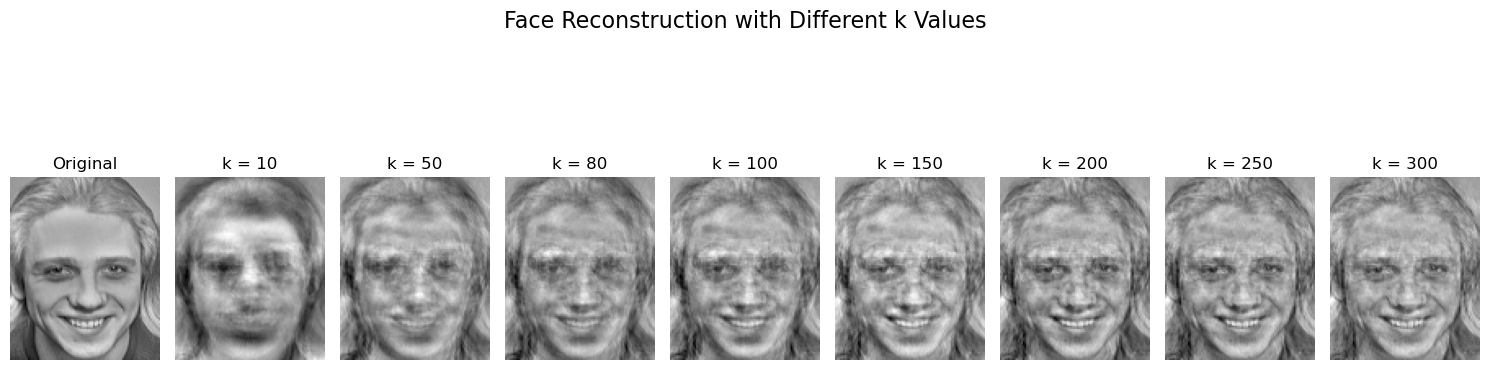

In [8]:
x = X_train[0]   
k_values = [10, 50, 80, 100, 150, 200, 250, 300]

plt.figure(figsize=(15, 5))

plt.subplot(1, len(k_values) + 1, 1)
plt.imshow(x.reshape(112, 92), cmap="gray")
plt.title("Original")
plt.axis("off")

for idx, k in enumerate(k_values, start=2):
    eigenfaces = eigvecs[:, :k].real
    
    proj = eigenfaces.T @ (x - mean_face)
    reconstructed = mean_face + eigenfaces @ proj
    
    plt.subplot(1, len(k_values) + 1, idx)
    plt.imshow(reconstructed.reshape(112, 92), cmap="gray")
    plt.title(f"k = {k}")
    plt.axis("off")

plt.suptitle("Face Reconstruction with Different k Values", fontsize=16)
plt.tight_layout()
plt.show()


In [9]:
k = 100  
eigenfaces = eigvecs[:, :k]

print("Eigenfaces shape:", eigenfaces.shape)

Eigenfaces shape: (10304, 100)


In [10]:
X_train_pca = X_train @ eigenfaces
X_test_pca = X_test @ eigenfaces

print("Train PCA shape:", X_train_pca.shape)
print("Test PCA shape:", X_test_pca.shape)

Train PCA shape: (300, 100)
Test PCA shape: (100, 100)


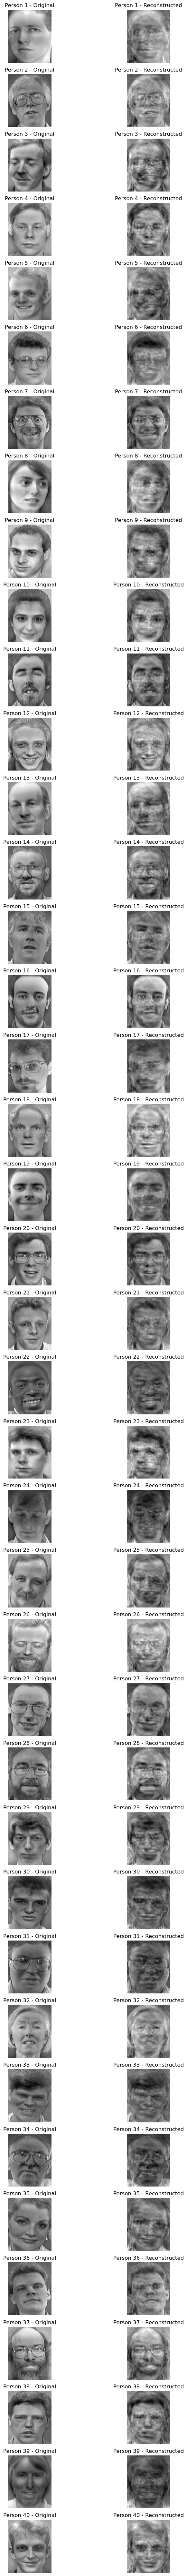

In [11]:
plt.figure(figsize=(10, 80))

for person in range(40):  
    idx = np.where(y_train == (person + 1))[0][0]
    x = X_train[idx]

    proj = eigvecs[:, :k].T @ (x - mean_face)
    reconstructed = mean_face + eigvecs[:, :k] @ proj

    plt.subplot(40, 2, 2*person + 1)
    plt.imshow(x.reshape(112, 92), cmap="gray")
    plt.axis("off")
    plt.title(f"Person {person+1} - Original")

    plt.subplot(40, 2, 2*person + 2)
    plt.imshow(reconstructed.real.reshape(112, 92), cmap="gray")
    plt.axis("off")
    plt.title(f"Person {person+1} - Reconstructed")
    
plt.tight_layout()
plt.show()

In [12]:
def nearest_neighbor(train_X, train_y, test_X):
    preds = []
    for x in test_X:
        dists = np.linalg.norm(train_X - x, axis=1)
        idx = np.argmin(dists)
        preds.append(train_y[idx])
    return np.array(preds)

y_pred = nearest_neighbor(X_train_pca, y_train, X_test_pca)

acc = np.mean(y_pred == y_test)
print("Recognition Accuracy with k =", k, ":", acc)

Recognition Accuracy with k = 100 : 0.97


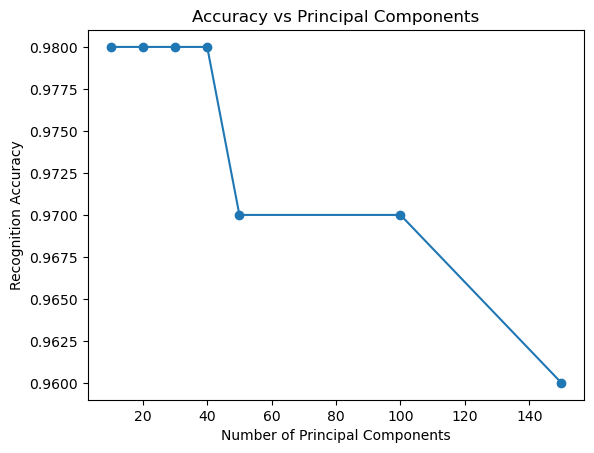

In [38]:
accuracies = []
components = [10, 20, 30, 40, 50, 100, 150]

for k in components:
    eigenfaces = eigvecs[:, :k]
    X_train_pca = X_train @ eigenfaces
    X_test_pca = X_test @ eigenfaces
    y_pred = nearest_neighbor(X_train_pca, y_train, X_test_pca)
    acc = np.mean(y_pred == y_test)
    accuracies.append(acc)

plt.plot(components, accuracies, marker="o")
plt.xlabel("Number of Principal Components")
plt.ylabel("Recognition Accuracy")
plt.title("Accuracy vs Principal Components")
plt.show()

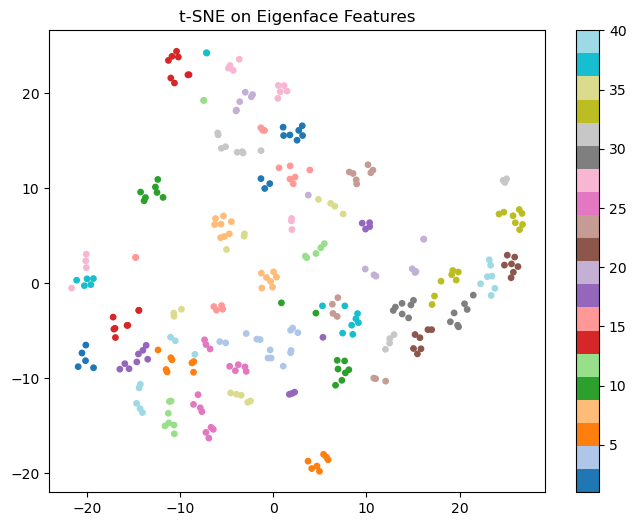

In [13]:
X_pca50 = (X_train @ eigvecs[:, :50]).real   

from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_pca50)

plt.figure(figsize=(8,6))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_train, cmap="tab20", s=15)
plt.colorbar()
plt.title("t-SNE on Eigenface Features")
plt.show()